<a href="https://colab.research.google.com/github/spdin/time-series-prediction-lstm-pytorch/blob/master/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression with Vanilla RNN

- Yongyang Liu


## Library

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F


In [2]:
# Path to save the trained model
Path = os.getcwd()
PATH = "Trained_model/RNN.pth"

#CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


## Data Loading

In [3]:
x = np.loadtxt('Sample_data/input.txt', delimiter='\t')
print(x.shape)

y = np.loadtxt('Sample_data/output.txt', delimiter='\t')
print(y.shape)

time_len    = 320                                   #time length for sample data for each vehicle           
veh_len     = 5                                     #vehicle length
seq_length  = 5                                     #Input sequency lenght, should not be too long. Use the past seq-length sample data to predict the next step state

time_length = len(x)                                #time length for total sample data
num_veh     = int(time_length/time_len)             #number of vehicles in sample data
print(num_veh)

(288000, 3)
(288000,)
900


## Data Processing

In [4]:
training_size = 700
validation_size = 100
testing_size = 100

dataX       = Variable(torch.Tensor(np.array(x)))   #Input data
dataY       = Variable(torch.Tensor(np.array(y)))   #Output target
sample_len  = time_len - seq_length                 # sample length from each vehicle

#Samples initialization
trainX      = Variable(torch.empty(training_size*sample_len, seq_length, 3))
trainY      = Variable(torch.empty(training_size*sample_len, 1))
for j in range(training_size): 
    for i in range(sample_len):
        #input data
        trainX[j*sample_len+i,0:seq_length] = dataX[j*time_len+i : j*time_len+i+seq_length]
        #output target
        trainY[j*sample_len+i] = dataY[j*time_len+i+seq_length]       
print(trainX.shape)
print(trainY.shape)

validX      = Variable(torch.empty(validation_size*sample_len, seq_length, 3))
validY      = Variable(torch.empty(validation_size*sample_len, 1))
for j in range(validation_size): 
    for i in range(sample_len):
        j_0 = j + training_size   
        validX[j*sample_len+i,0:seq_length] = dataX[j_0*time_len+i : j_0*time_len+i+seq_length]       
        validY[j*sample_len+i] = dataY[j_0*time_len+i+seq_length]     
print(validX.shape)
print(validY.shape)

testX       = Variable(torch.empty(validation_size*sample_len, seq_length, 3)) 
testY       = Variable(torch.empty(validation_size*sample_len, 1))
for j in range(testing_size): 
    for i in range(sample_len):
        j_0 = j + training_size + validation_size
        testX[j*sample_len+i,0:seq_length] = dataX[j_0*time_len+i : j_0*time_len+i+seq_length]       
        testY[j*sample_len+i] = dataY[j_0*time_len+i+seq_length]     
print(testX.shape)
print(testY.shape)



#CUDA
trainX = trainX.to(device)
trainY = trainY.to(device)
validX = validX.to(device)
validY = validY.to(device)
testX = testX.to(device)
testY = testY.to(device)


torch.Size([220500, 5, 3])
torch.Size([220500, 1])
torch.Size([31500, 5, 3])
torch.Size([31500, 1])
torch.Size([31500, 5, 3])
torch.Size([31500, 1])


## Model

In [5]:
class RNN(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size1, hidden_size2, num_layers): 
        super(RNN, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        
        self.gru1 = nn.RNN(input_size=input_size, hidden_size=hidden_size1, num_layers=num_layers, batch_first = True)
        self.gru2 = nn.RNN(input_size=hidden_size1, hidden_size=hidden_size2, num_layers=num_layers, batch_first = True)
        
        self.fc1 = nn.Linear(hidden_size2, int(hidden_size2/2))
        self.bn1 = nn.BatchNorm1d(int(hidden_size2/2))
        self.fc2 = nn.Linear(int(hidden_size2/2), int(hidden_size2/4))  
        self.bn2 = nn.BatchNorm1d(int(hidden_size2/4))
        self.fc3 = nn.Linear(int(hidden_size2/4), num_classes)
        
        self.drop1 = nn.Dropout(p=0.5)
        self.drop2 = nn.Dropout(p=0.5)

    def forward(self, x):
        h_00 = Variable(torch.randn(self.num_layers, x.size(0), self.hidden_size1)).to(device)
        h_01 = Variable(torch.randn(self.num_layers, x.size(0), self.hidden_size2)).to(device)
        
        # Propagate input through RNN
        out, _ = self.gru1(x, h_00)
        uls, h_out = self.gru2(out, h_01)          # seq_2_one, so we use h_out instead of uls
        
        h_out = h_out.view(-1, self.hidden_size2)
        output = F.relu(self.drop1(self.bn1(self.fc1(h_out))))
        output = F.relu(self.drop2(self.bn2(self.fc2(output))))
        output = self.fc3(output)
        
        return output

## Training

Model's state_dict:
gru1.weight_ih_l0 	 torch.Size([128, 3])
gru1.weight_hh_l0 	 torch.Size([128, 128])
gru1.bias_ih_l0 	 torch.Size([128])
gru1.bias_hh_l0 	 torch.Size([128])
gru2.weight_ih_l0 	 torch.Size([64, 128])
gru2.weight_hh_l0 	 torch.Size([64, 64])
gru2.bias_ih_l0 	 torch.Size([64])
gru2.bias_hh_l0 	 torch.Size([64])
fc1.weight 	 torch.Size([32, 64])
fc1.bias 	 torch.Size([32])
bn1.weight 	 torch.Size([32])
bn1.bias 	 torch.Size([32])
bn1.running_mean 	 torch.Size([32])
bn1.running_var 	 torch.Size([32])
bn1.num_batches_tracked 	 torch.Size([])
fc2.weight 	 torch.Size([16, 32])
fc2.bias 	 torch.Size([16])
bn2.weight 	 torch.Size([16])
bn2.bias 	 torch.Size([16])
bn2.running_mean 	 torch.Size([16])
bn2.running_var 	 torch.Size([16])
bn2.num_batches_tracked 	 torch.Size([])
fc3.weight 	 torch.Size([1, 16])
fc3.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params'

C:\Users\yliu3119\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
C:\Users\yliu3119\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


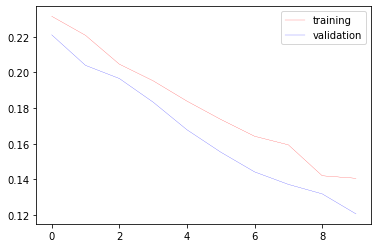

Epoch: 10, loss_train: 0.011197977699, loss_valid: 0.008361238055, best loss: 0.008262932301
Epoch: 20, loss_train: 0.003409569617, loss_valid: 0.004058983177, best loss: 0.003814783180
Epoch: 30, loss_train: 0.002533911727, loss_valid: 0.003039166797, best loss: 0.002852781443
Epoch: 40, loss_train: 0.002082857769, loss_valid: 0.002424399136, best loss: 0.002272774000
Epoch: 50, loss_train: 0.001971789869, loss_valid: 0.002072853036, best loss: 0.002021569759
Epoch L1 regularization 0.00000002


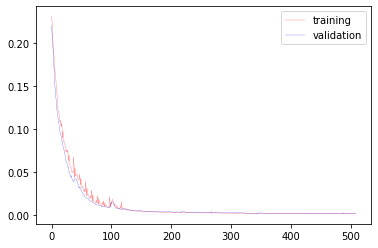

Epoch: 60, loss_train: 0.001795897144, loss_valid: 0.001856477931, best loss: 0.001797391917
Epoch: 70, loss_train: 0.001672860351, loss_valid: 0.001765613677, best loss: 0.001658806927
Epoch: 80, loss_train: 0.001715023420, loss_valid: 0.001651008031, best loss: 0.001583238249
Epoch: 90, loss_train: 0.001536120893, loss_valid: 0.001585436985, best loss: 0.001494435710
Epoch: 100, loss_train: 0.001554101123, loss_valid: 0.001552357106, best loss: 0.001445537084
Epoch L1 regularization 0.00000002


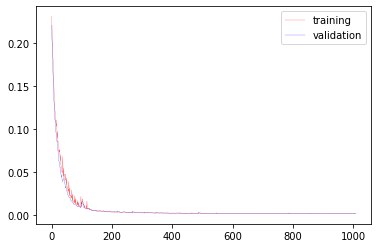

Epoch: 110, loss_train: 0.001387011958, loss_valid: 0.001476068981, best loss: 0.001427187002
Epoch: 120, loss_train: 0.001468023518, loss_valid: 0.001511956681, best loss: 0.001361115021
Epoch: 130, loss_train: 0.001405859250, loss_valid: 0.001397234271, best loss: 0.001359957270
Epoch: 140, loss_train: 0.001330001280, loss_valid: 0.001436981023, best loss: 0.001347331563
Epoch: 150, loss_train: 0.001380666508, loss_valid: 0.001362581621, best loss: 0.001311437925
Epoch L1 regularization 0.00000002


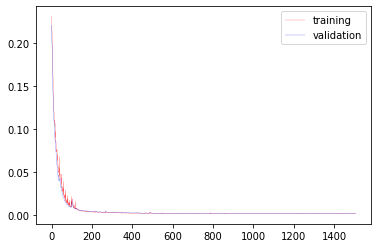

Epoch: 160, loss_train: 0.001424842747, loss_valid: 0.001397913438, best loss: 0.001311437925
Epoch: 170, loss_train: 0.001335453358, loss_valid: 0.001321886666, best loss: 0.001282408950
Epoch: 180, loss_train: 0.001279778779, loss_valid: 0.001287593739, best loss: 0.001279538614
Epoch: 190, loss_train: 0.001310741995, loss_valid: 0.001327376347, best loss: 0.001273042057
Epoch: 200, loss_train: 0.001332448563, loss_valid: 0.001311584492, best loss: 0.001269719913
Epoch L1 regularization 0.00000002


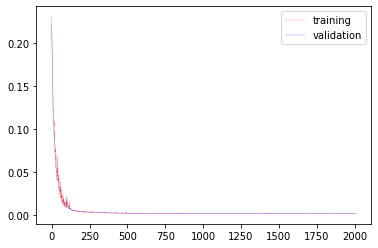

Epoch: 210, loss_train: 0.001280299621, loss_valid: 0.001290271874, best loss: 0.001249937573
Epoch: 220, loss_train: 0.001263575978, loss_valid: 0.001353279105, best loss: 0.001239529112
Epoch: 230, loss_train: 0.001285666483, loss_valid: 0.001274269540, best loss: 0.001233334537
Epoch: 240, loss_train: 0.001328394515, loss_valid: 0.001293717767, best loss: 0.001224297448
Epoch: 250, loss_train: 0.001271729940, loss_valid: 0.001254299423, best loss: 0.001223137253
Epoch L1 regularization 0.00000002


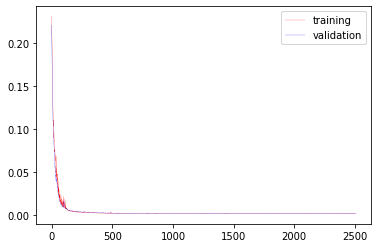

Epoch: 260, loss_train: 0.001277354895, loss_valid: 0.001263205893, best loss: 0.001211223891
Epoch: 270, loss_train: 0.001305041136, loss_valid: 0.001247922191, best loss: 0.001211223891
Epoch: 280, loss_train: 0.001275209477, loss_valid: 0.001279970282, best loss: 0.001202205312
Epoch: 290, loss_train: 0.001325514400, loss_valid: 0.001254540868, best loss: 0.001184137189
Epoch: 300, loss_train: 0.001268651336, loss_valid: 0.001246312051, best loss: 0.001184137189
Epoch L1 regularization 0.00000002


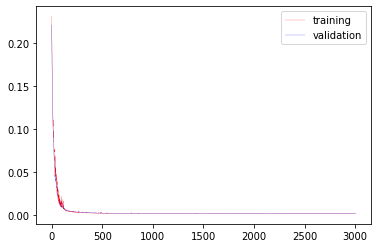

In [6]:
#hidden size is bigger, the accuracy is higher, but higher computation
#if the learning rate is too big, then loss may be stuck at a certain 
#and cannot go down. So, if the loss goes down to a certain value and
#then cannot decrease, just change a smaller learning rate.


num_epochs    = 301
learning_rate = 0.001
L1_lambda     = 0.00000000001

input_size   = trainX.size(2)
hidden_size1 = 128
hidden_size2 = 64
num_classes = trainY.size(1)
num_layers = 1

model = RNN(num_classes, input_size, hidden_size1, hidden_size2, num_layers) 
model.to(device)  #CUDA

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#learning rate adjustment. learning rate * 0.75 every 2000 epoch
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.75)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

best_loss = 99999999999999.99
best_epoch = 0
Loss = [] 
Loss_t = []
t_len = int(trainX.size(0)/10)
# Train the model

for epoch in range(num_epochs):   
    for j in range(10):     # input size is too big. We split into 10 piece
        torch.cuda.empty_cache()
        train_X_temp = trainX[j*t_len:j*t_len+t_len] # 0 to test_size
        train_Y_temp = trainY[j*t_len:j*t_len+t_len]
        
        train_X_temp = train_X_temp.to(device)
        train_Y_temp = train_Y_temp.to(device)
        
        outputs = model(train_X_temp)
        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(outputs, train_Y_temp)
        # L1 regularization
        L1_reg = torch.tensor(0., requires_grad=True)
        for name, param in model.named_parameters():
            if 'weight' in name:
                L1_reg = L1_reg + torch.norm(param, 1)
            
        loss += L1_lambda * L1_reg

        loss.backward()
        
        optimizer.step()
        #scheduler.step()
        
        outputs = model(testX)
        loss_t = criterion(outputs, testY)# + L1_lambda * L1_reg
    
        Loss.append(loss.item())
        Loss_t.append(loss_t.item())
        
        if loss_t.item() < best_loss:
            torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        }, PATH)
            best_loss = loss_t.item()
    
    if epoch % 10 == 0:
        print("Epoch: %d, loss_train: %1.12f, loss_valid: %1.12f, best loss: %1.12f" % (epoch, loss.item(), loss_t.item(), best_loss))
              
    if epoch % 50 == 0:
        print("Epoch L1 regularization %1.8f" % (L1_lambda * L1_reg))
        plt.plot(Loss,c='r', linewidth=0.2, Label = 'training')
        plt.plot(Loss_t,c='b', linewidth=0.2, Label = 'validation')
        #plt.ylim(0, 0.00001)
        #plt.axhline(y=0.0002, c='black', linestyle='--', linewidth=0.1)
        #plt.axhline(y=0.0001, c='black', linestyle='--', linewidth=0.1)
        plt.legend()
        plt.show()



## Save model

In [37]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

## Load model

In [7]:
num_epochs    = 301
learning_rate = 0.001
L1_lambda     = 0.00000000001

input_size   = trainX.size(2)
hidden_size1 = 128
hidden_size2 = 64
num_classes = trainY.size(1)
num_layers = 1

model = RNN(num_classes, input_size, hidden_size1, hidden_size2, num_layers) 
model.to(device)  #CUDA

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

if device == "cuda:0":
    checkpoint = torch.load(PATH)
else:
    checkpoint = torch.load(PATH, map_location = torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


## Test

vehicle 0  MSE Loss: 0.00094130


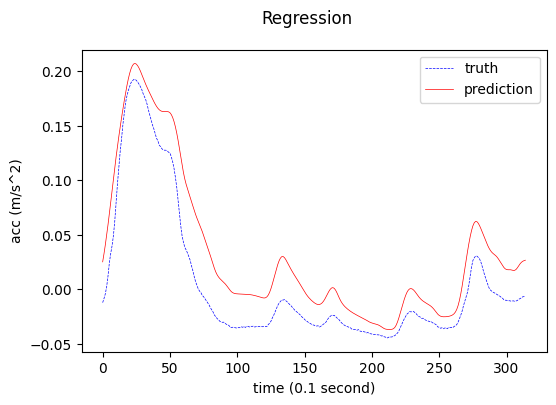

vehicle 1  MSE Loss: 0.00159466


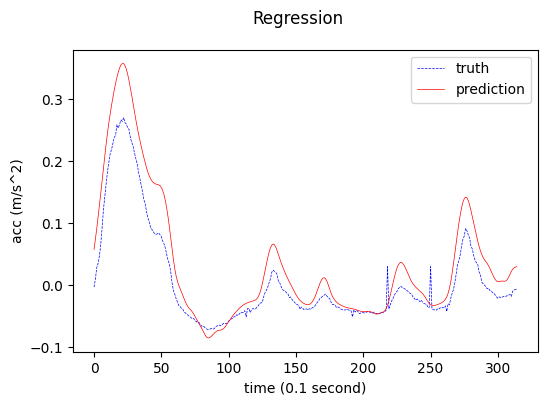

vehicle 2  MSE Loss: 0.00118536


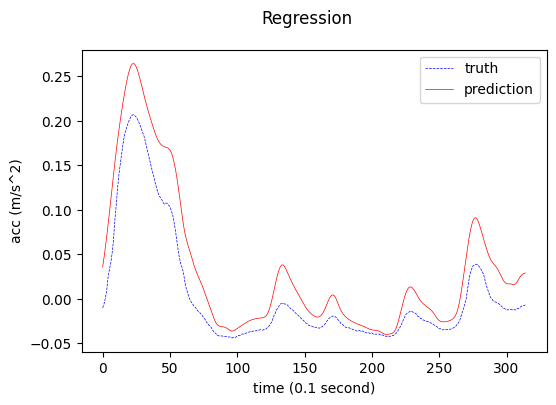

vehicle 3  MSE Loss: 0.00096427


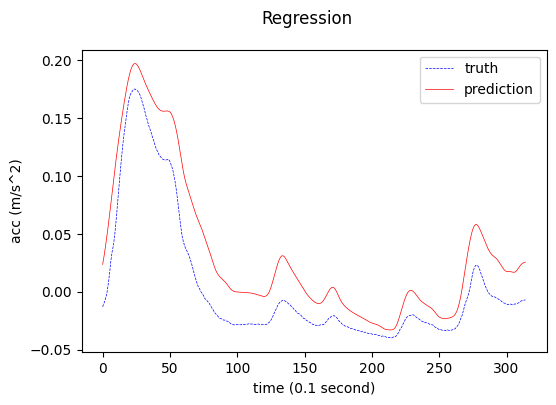

vehicle 4  MSE Loss: 0.00119320


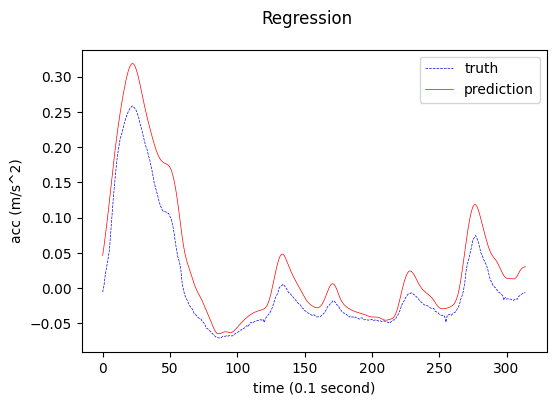

vehicle 5  MSE Loss: 0.00097863


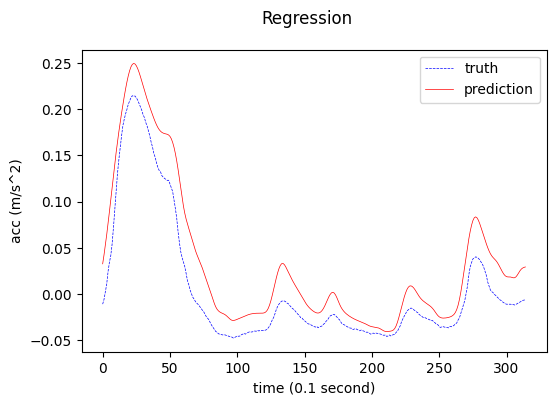

vehicle 6  MSE Loss: 0.00104820


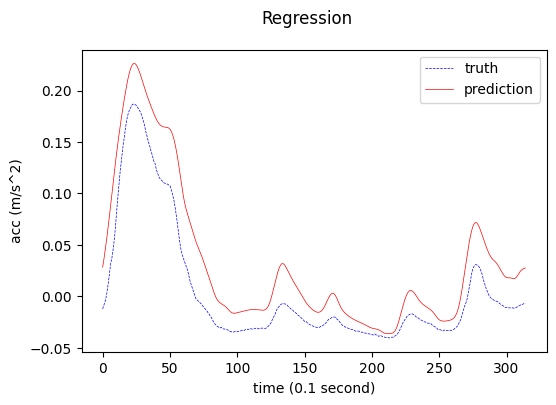

vehicle 7  MSE Loss: 0.00122360


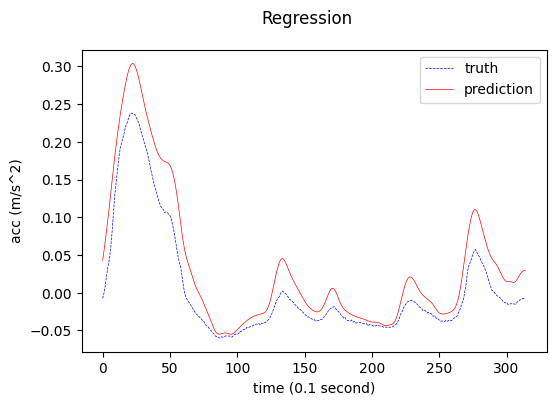

vehicle 8  MSE Loss: 0.00102605


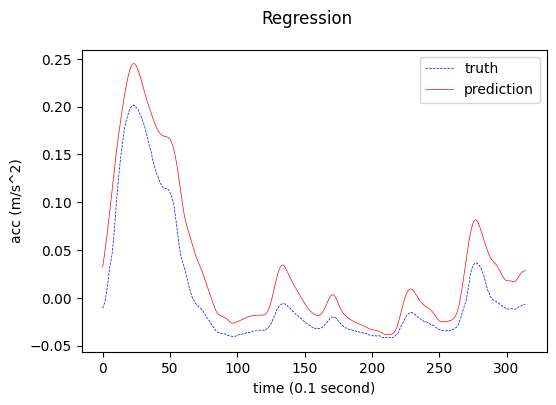

vehicle 9  MSE Loss: 0.00099802


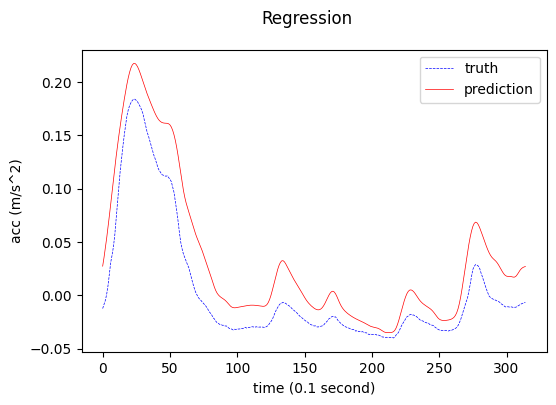

vehicle 10  MSE Loss: 0.00113038


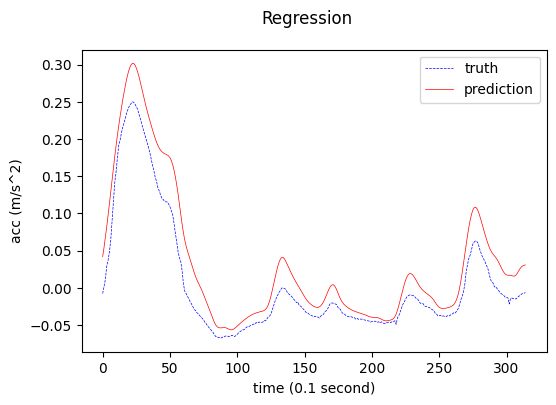

vehicle 11  MSE Loss: 0.00130165


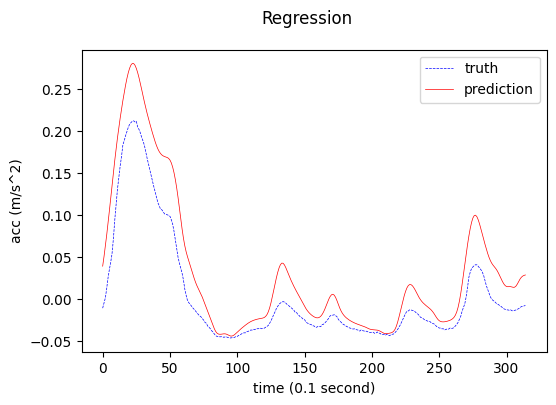

vehicle 12  MSE Loss: 0.00103210


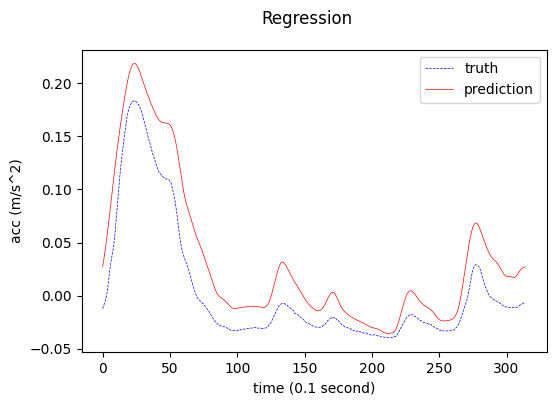

vehicle 13  MSE Loss: 0.00113930


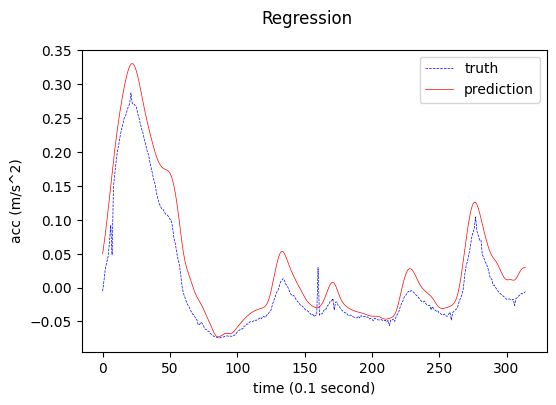

vehicle 14  MSE Loss: 0.00097183


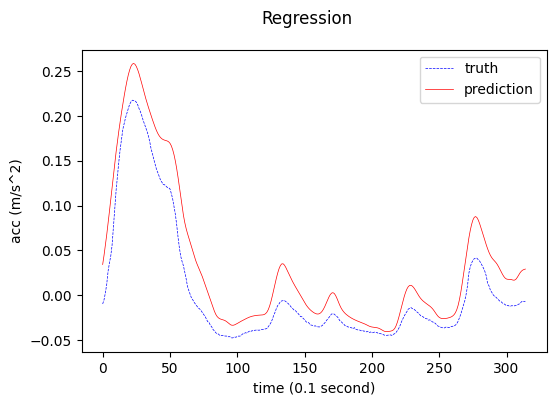

vehicle 15  MSE Loss: 0.00108368


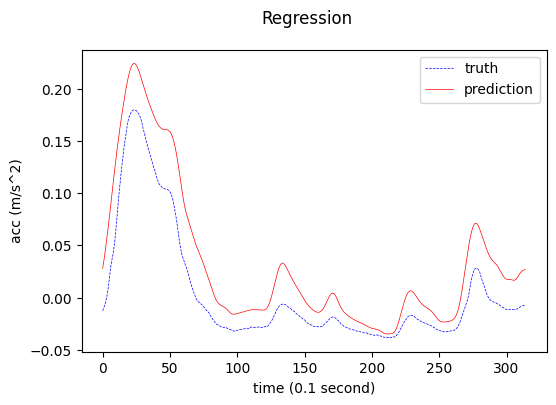

vehicle 16  MSE Loss: 0.00109579


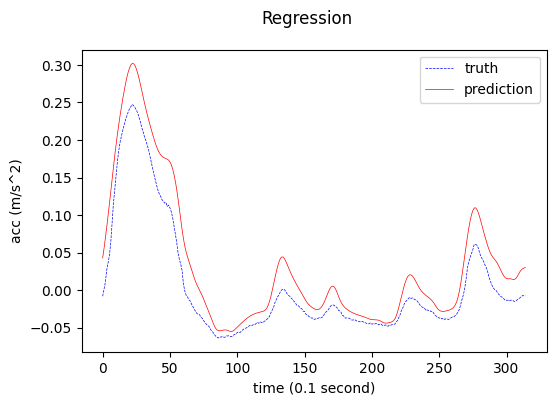

vehicle 17  MSE Loss: 0.00101666


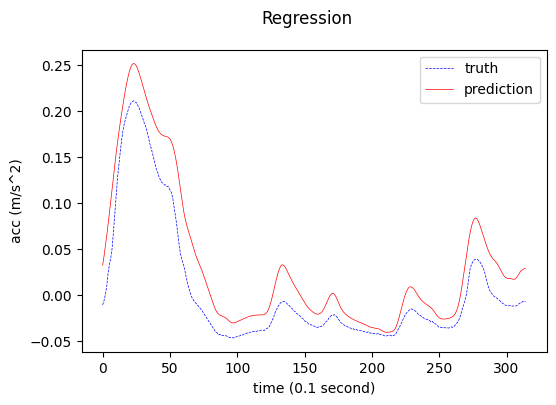

vehicle 18  MSE Loss: 0.00098880


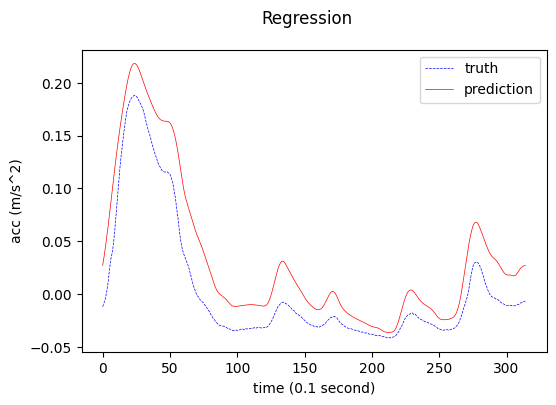

vehicle 19  MSE Loss: 0.00180016


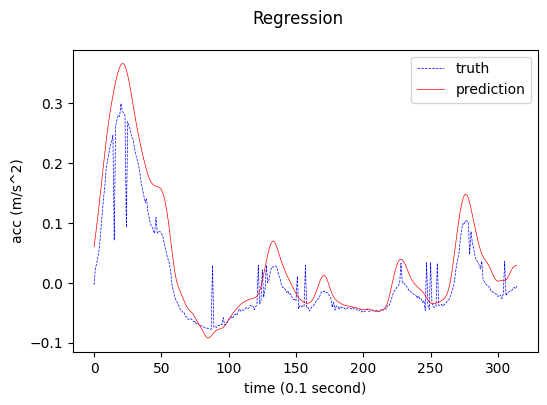

vehicle 20  MSE Loss: 0.00086309


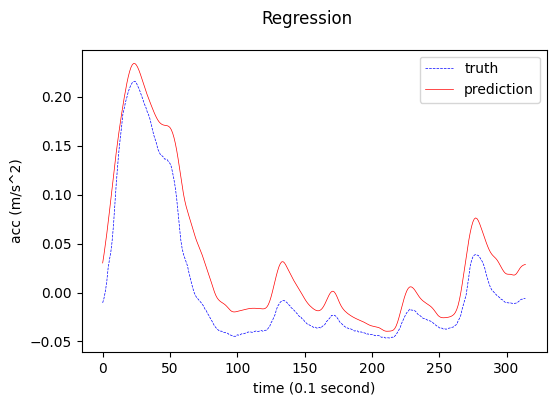

vehicle 21  MSE Loss: 0.00092197


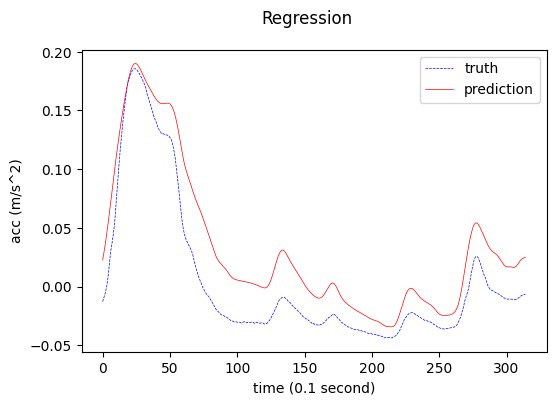

vehicle 22  MSE Loss: 0.00118251


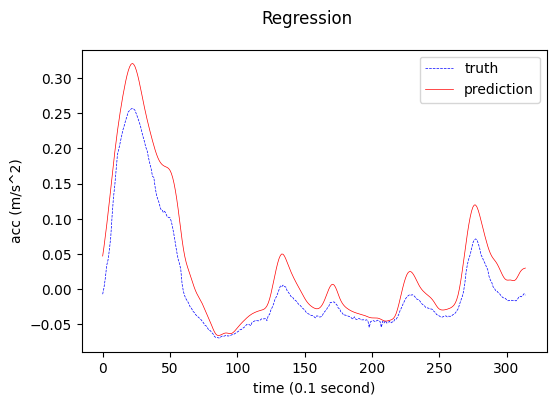

vehicle 23  MSE Loss: 0.00122248


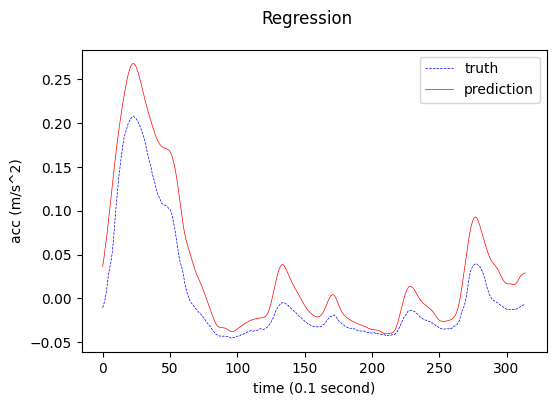

vehicle 24  MSE Loss: 0.00103566


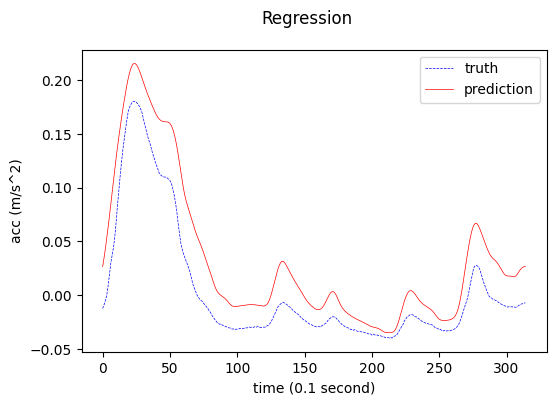

vehicle 25  MSE Loss: 0.00101188


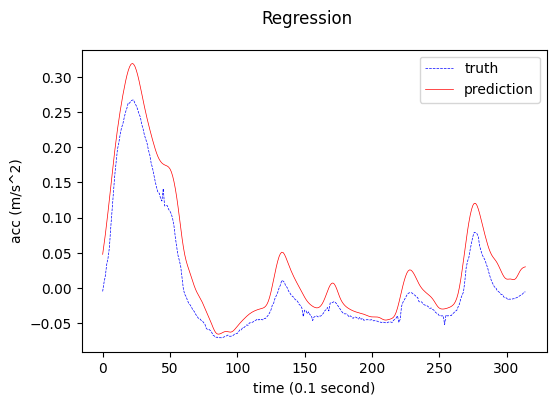

vehicle 26  MSE Loss: 0.00109376


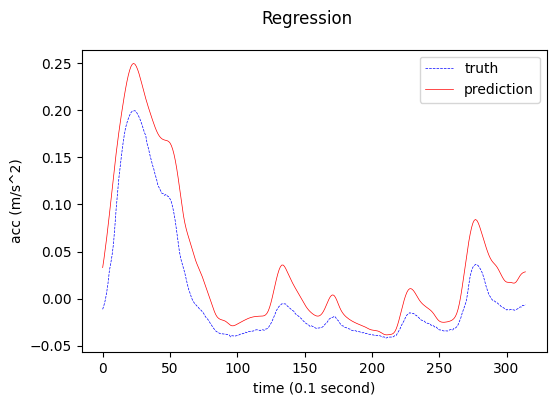

vehicle 27  MSE Loss: 0.00096632


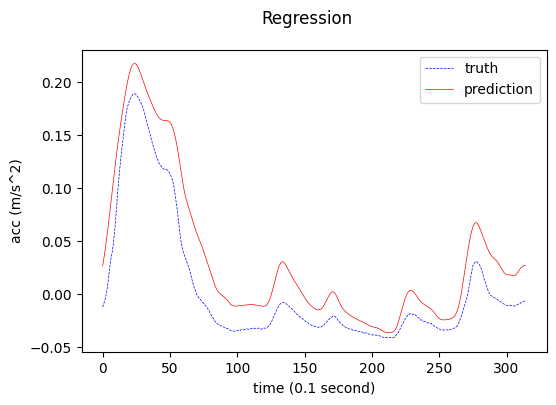

vehicle 28  MSE Loss: 0.00121255


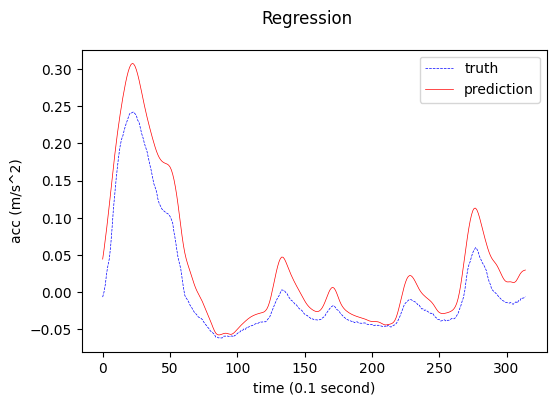

vehicle 29  MSE Loss: 0.00121508


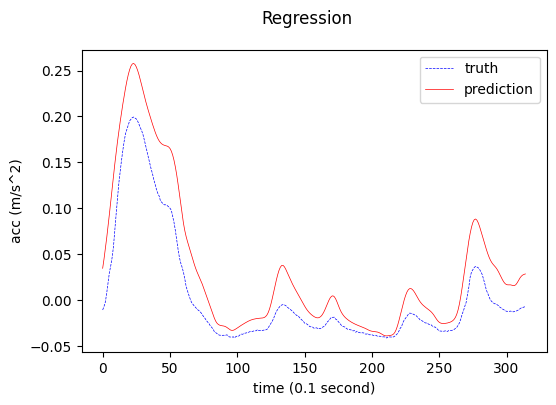

vehicle 30  MSE Loss: 0.00101577


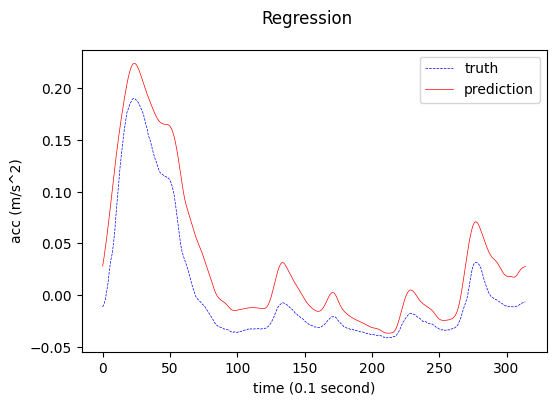

vehicle 31  MSE Loss: 0.00109848


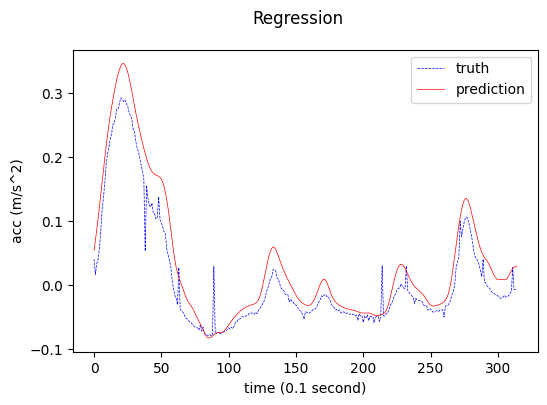

vehicle 32  MSE Loss: 0.00101374


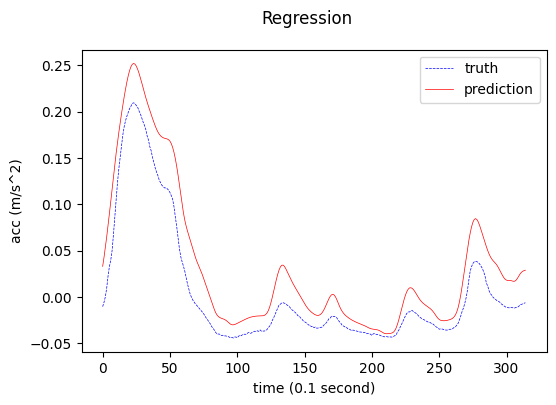

vehicle 33  MSE Loss: 0.00096450


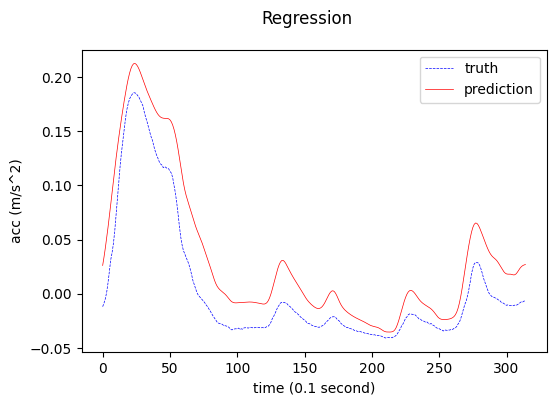

vehicle 34  MSE Loss: 0.00115270


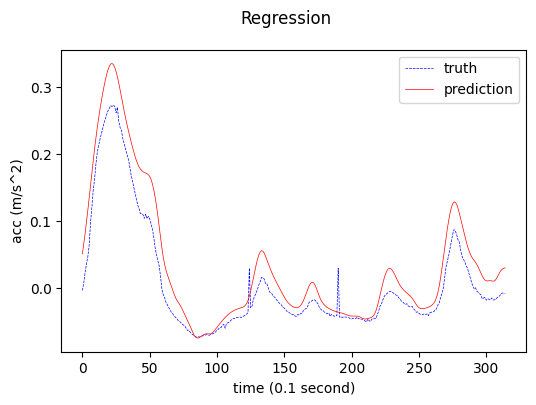

vehicle 35  MSE Loss: 0.00096814


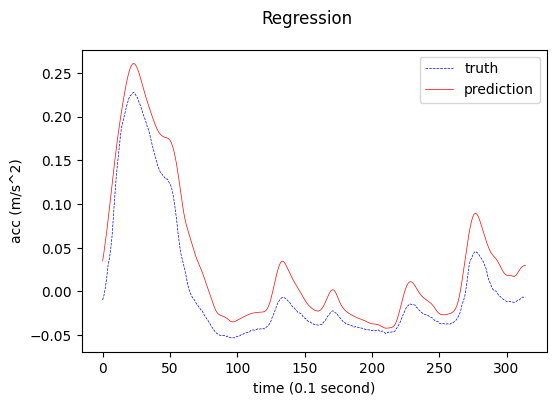

vehicle 36  MSE Loss: 0.00110757


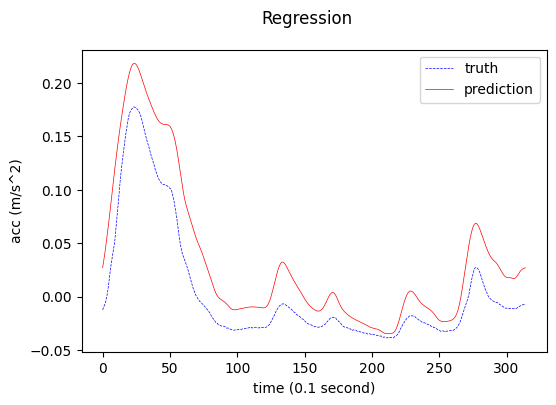

vehicle 37  MSE Loss: 0.00138485


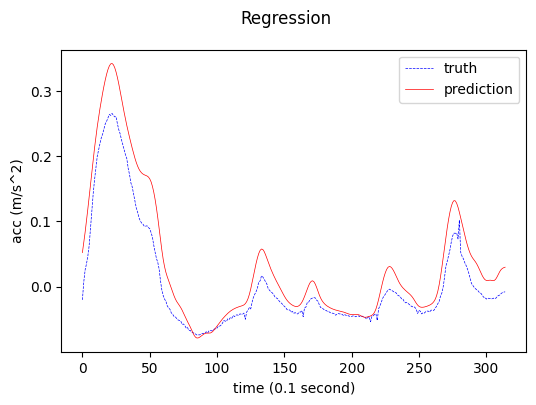

vehicle 38  MSE Loss: 0.00126197


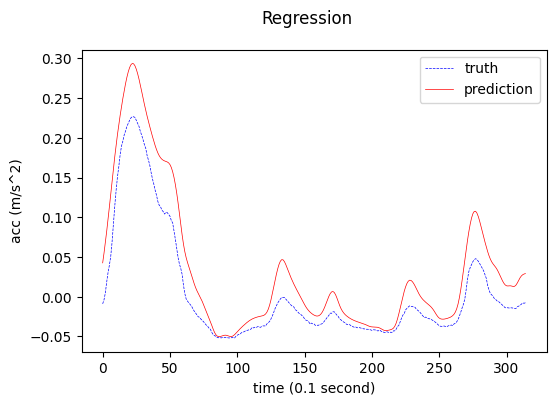

vehicle 39  MSE Loss: 0.00121028


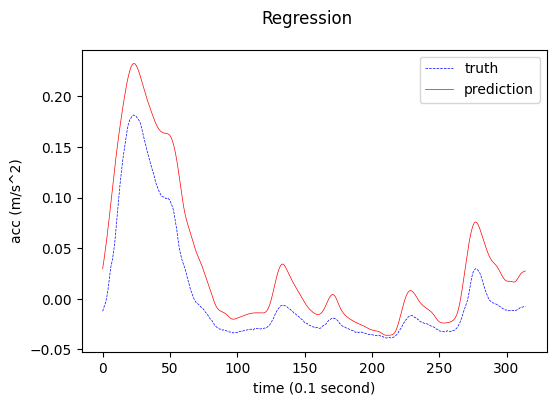

vehicle 40  MSE Loss: 0.00137850


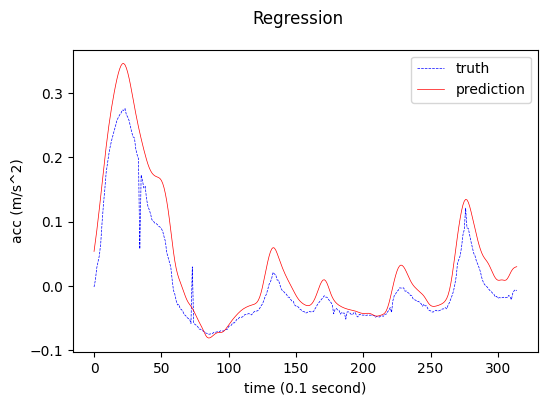

vehicle 41  MSE Loss: 0.00114079


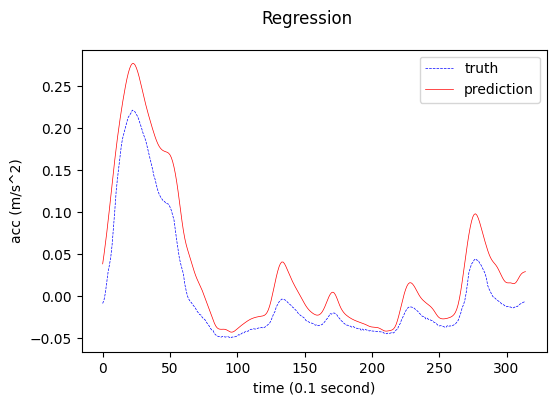

vehicle 42  MSE Loss: 0.00106285


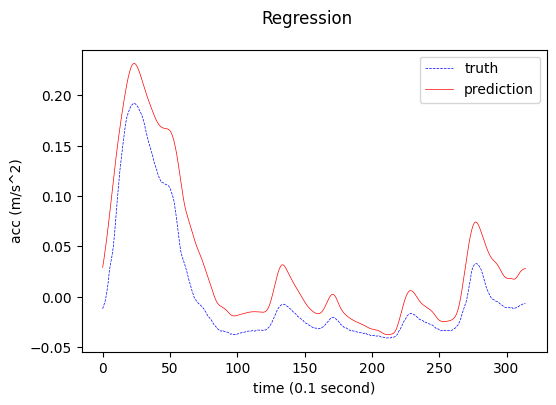

vehicle 43  MSE Loss: 0.00113227


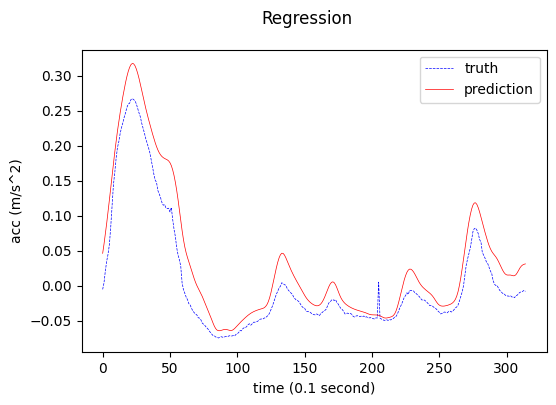

vehicle 44  MSE Loss: 0.00108481


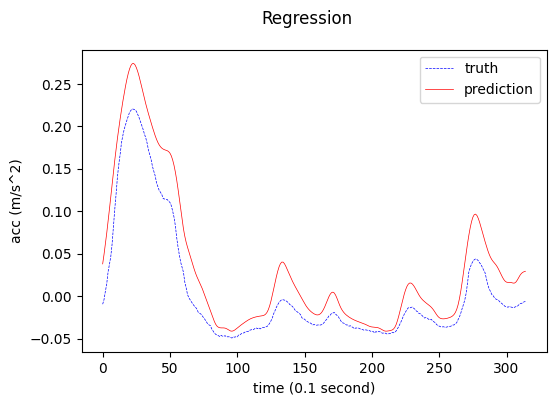

vehicle 45  MSE Loss: 0.00108793


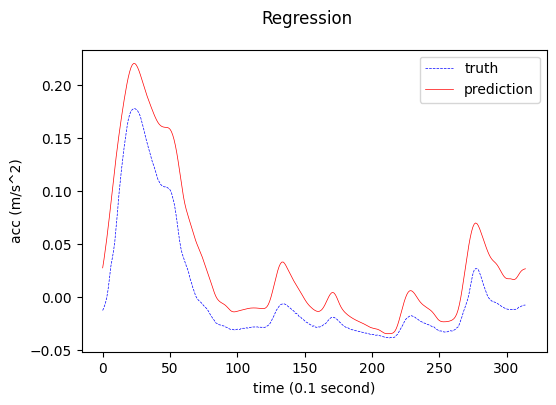

vehicle 46  MSE Loss: 0.00100892


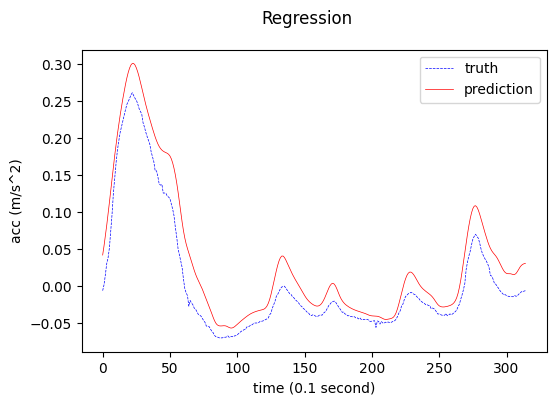

vehicle 47  MSE Loss: 0.00107630


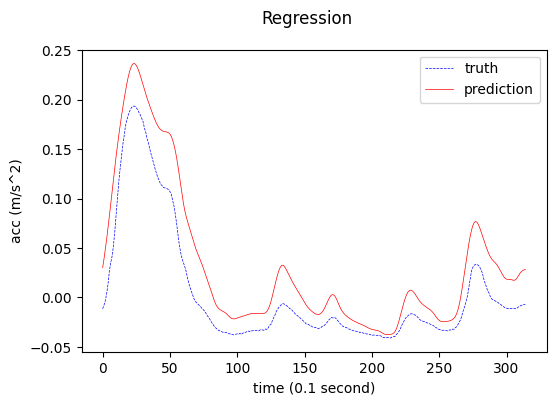

vehicle 48  MSE Loss: 0.00096865


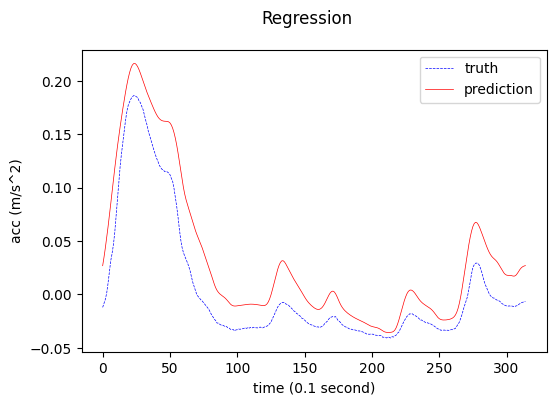

vehicle 49  MSE Loss: 0.00130507


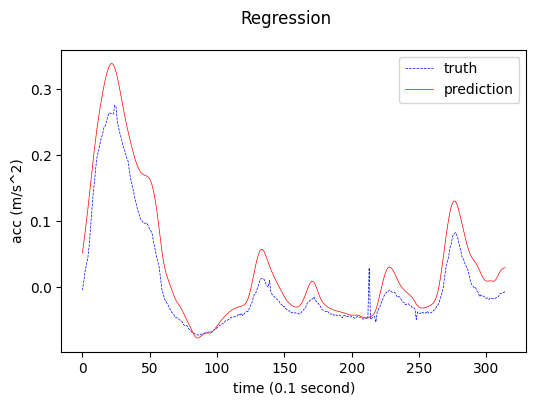

vehicle 50  MSE Loss: 0.00108215


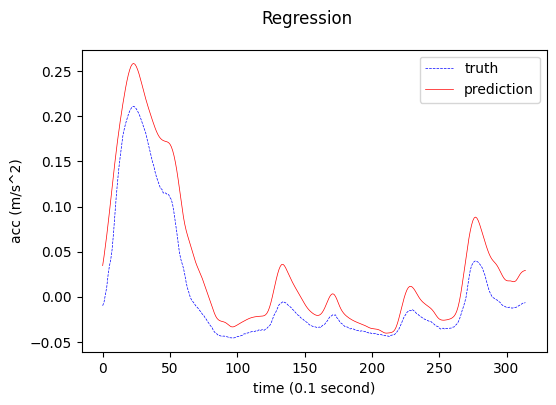

vehicle 51  MSE Loss: 0.00096855


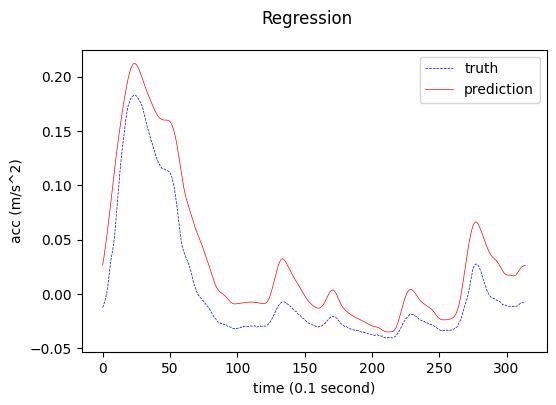

vehicle 52  MSE Loss: 0.00096741


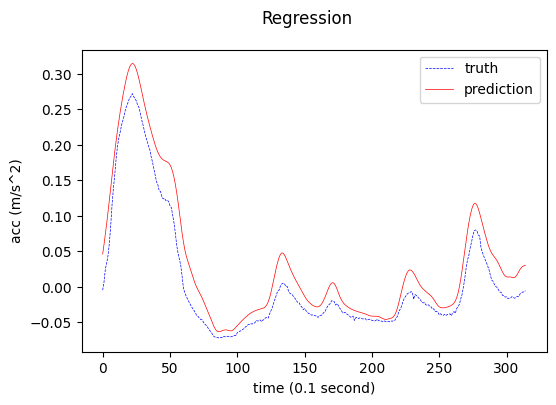

vehicle 53  MSE Loss: 0.00116509


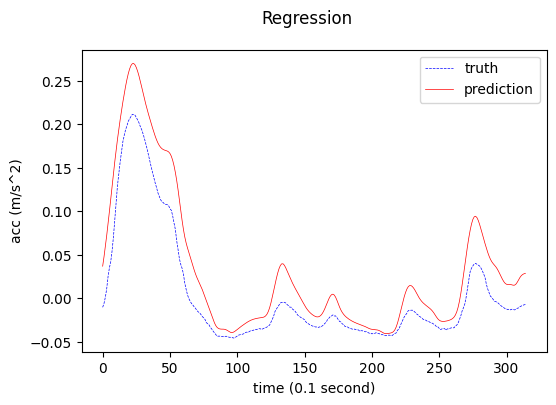

vehicle 54  MSE Loss: 0.00107168


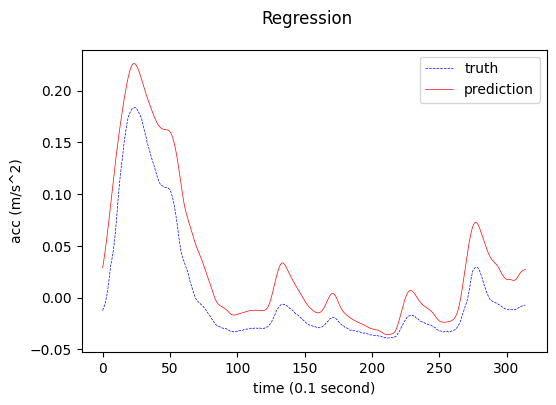

vehicle 55  MSE Loss: 0.00142605


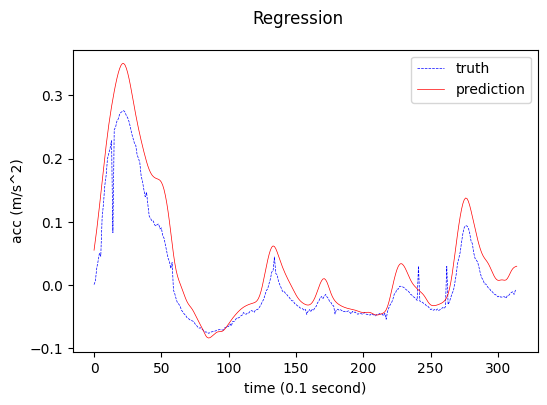

vehicle 56  MSE Loss: 0.00093661


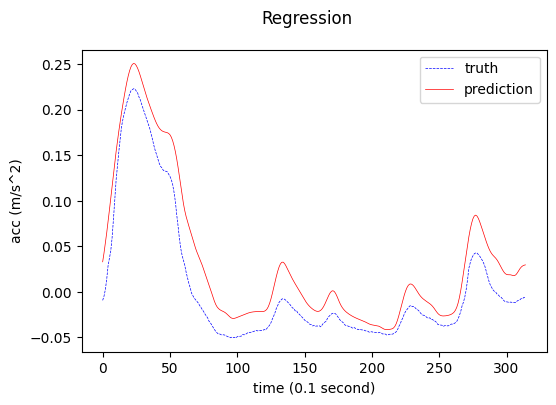

vehicle 57  MSE Loss: 0.00107675


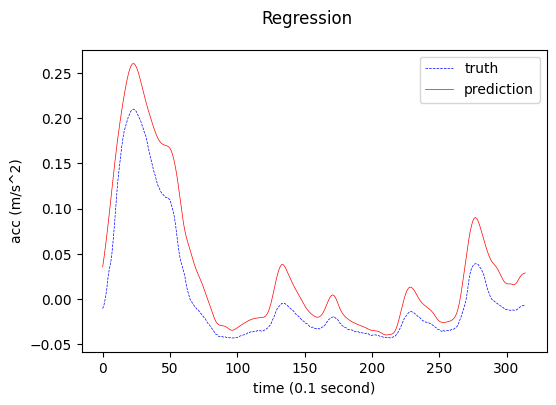

vehicle 58  MSE Loss: 0.00141230


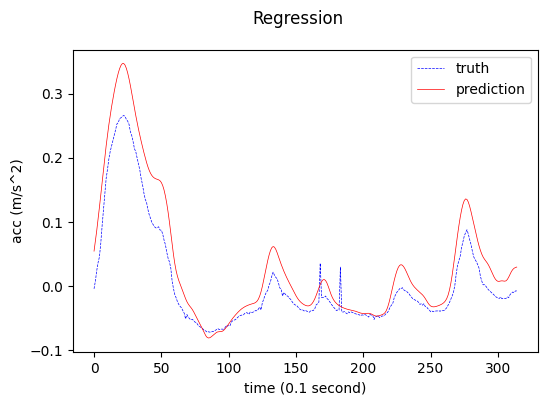

vehicle 59  MSE Loss: 0.00126338


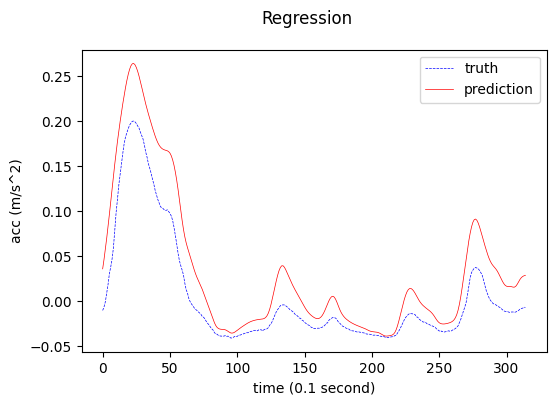

vehicle 60  MSE Loss: 0.00089827


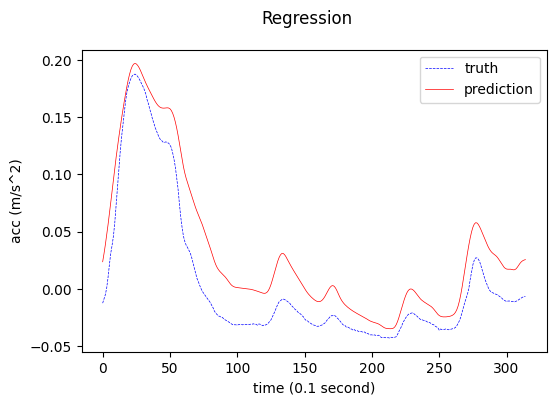

vehicle 61  MSE Loss: 0.00113122


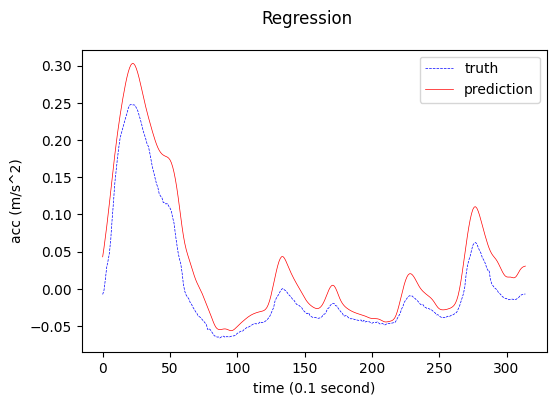

vehicle 62  MSE Loss: 0.00108891


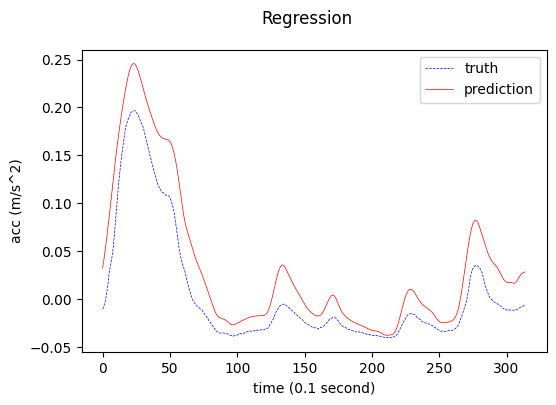

vehicle 63  MSE Loss: 0.00106320


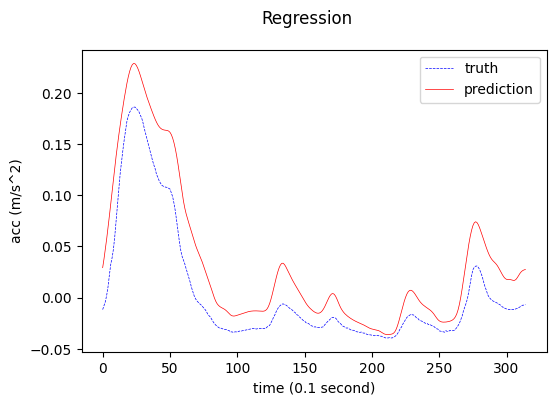

vehicle 64  MSE Loss: 0.00161066


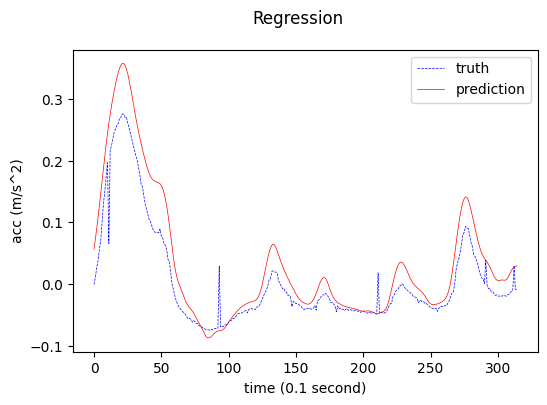

vehicle 65  MSE Loss: 0.00099221


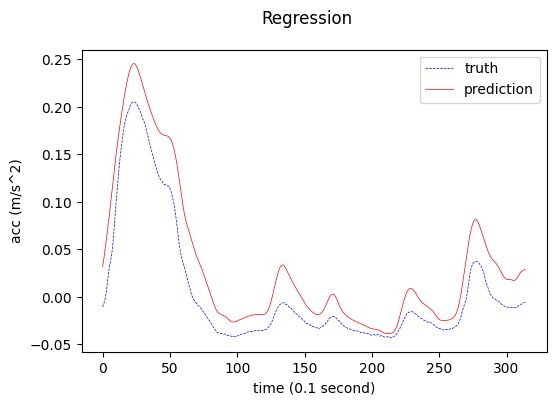

vehicle 66  MSE Loss: 0.00096807


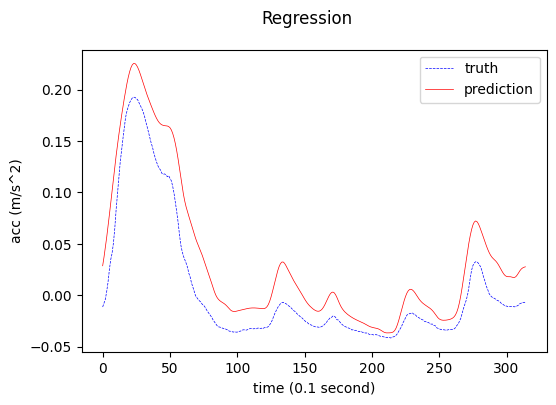

vehicle 67  MSE Loss: 0.00108054


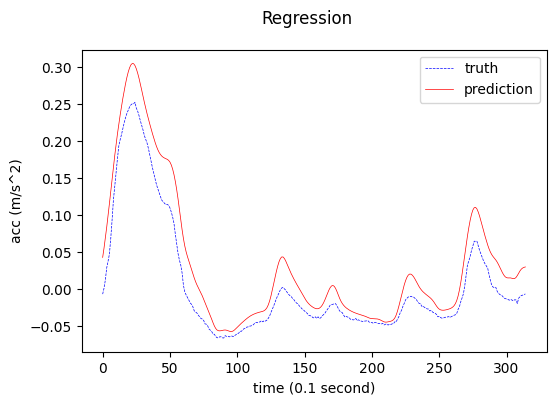

vehicle 68  MSE Loss: 0.00100896


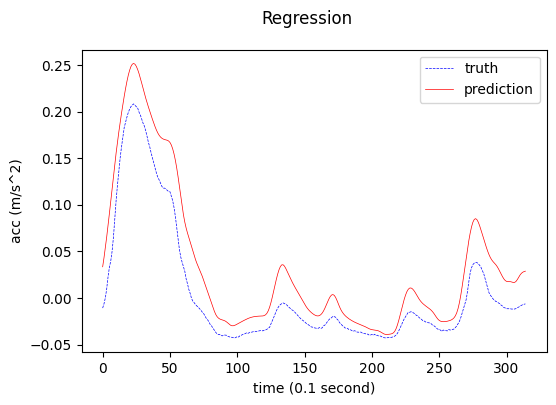

vehicle 69  MSE Loss: 0.00111835


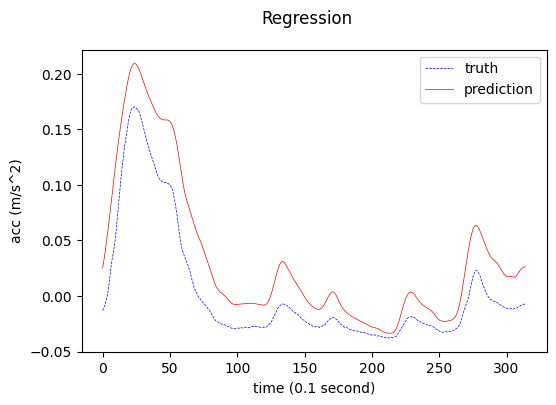

vehicle 70  MSE Loss: 0.00372121


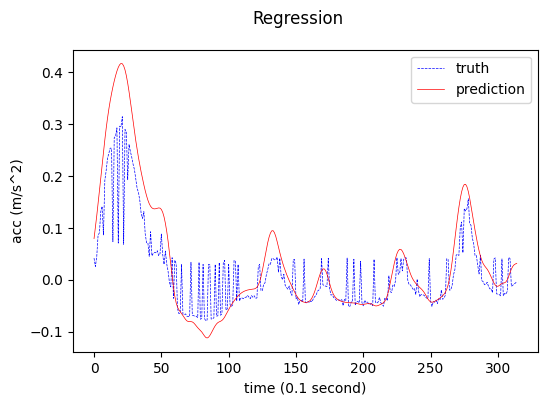

vehicle 71  MSE Loss: 0.00126663


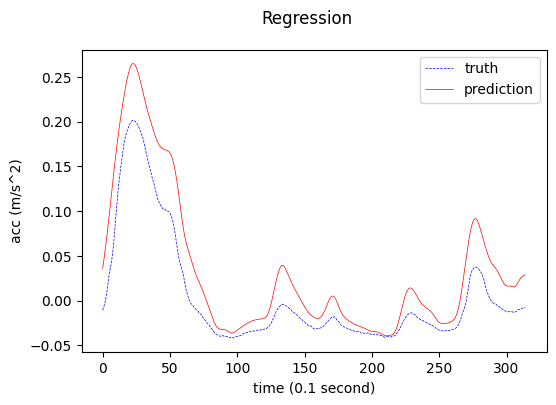

vehicle 72  MSE Loss: 0.00115901


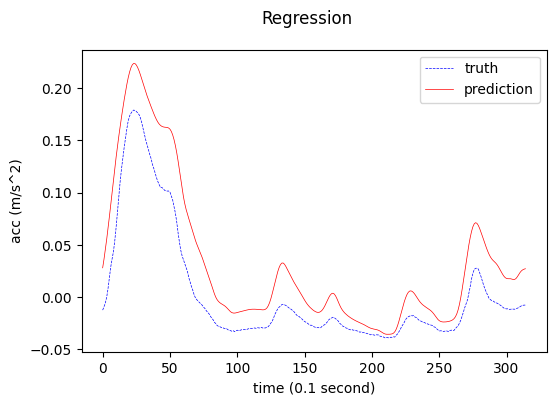

vehicle 73  MSE Loss: 0.00117201


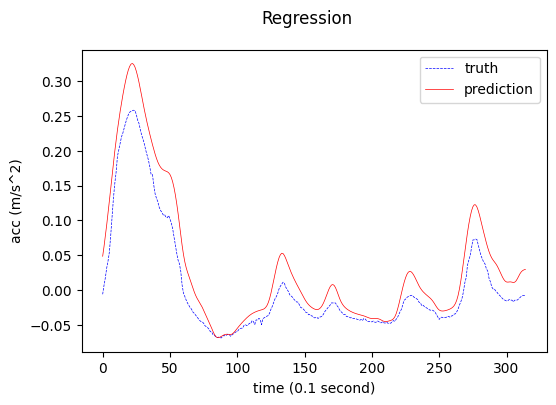

vehicle 74  MSE Loss: 0.00133864


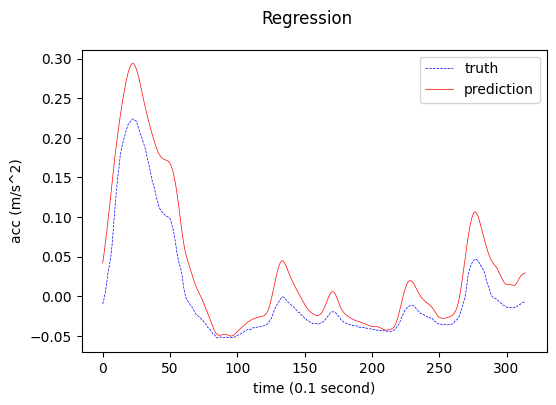

vehicle 75  MSE Loss: 0.00111154


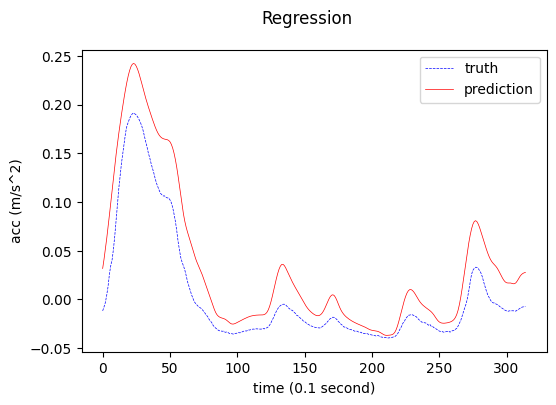

vehicle 76  MSE Loss: 0.00124375


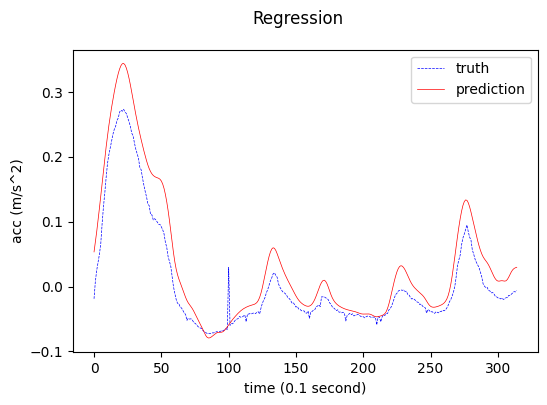

vehicle 77  MSE Loss: 0.00110875


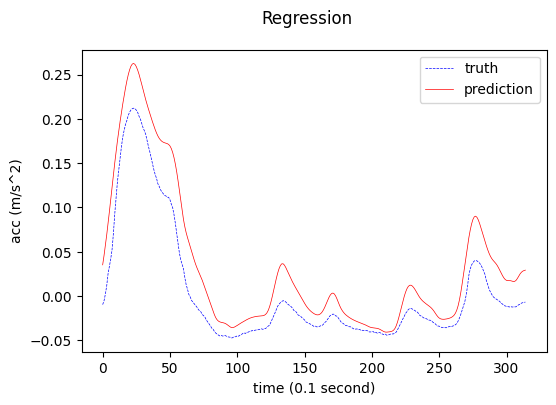

vehicle 78  MSE Loss: 0.00101219


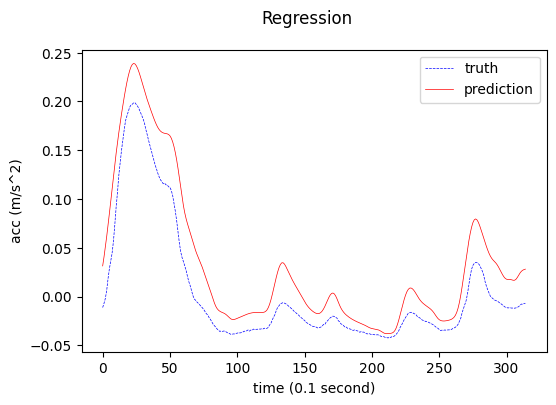

vehicle 79  MSE Loss: 0.00115488


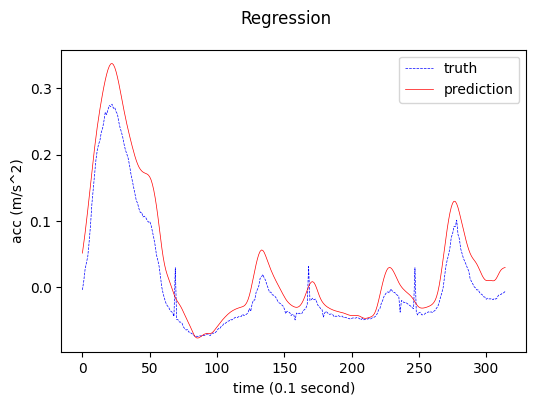

vehicle 80  MSE Loss: 0.00101804


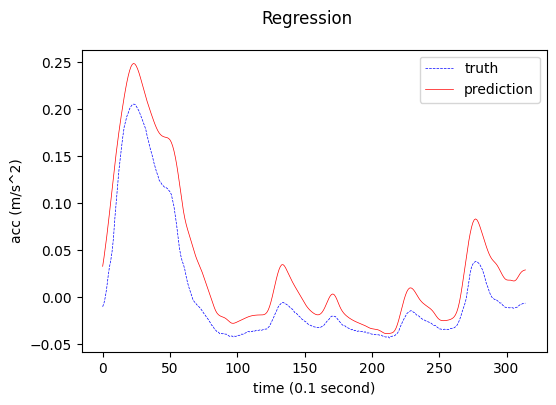

vehicle 81  MSE Loss: 0.00096227


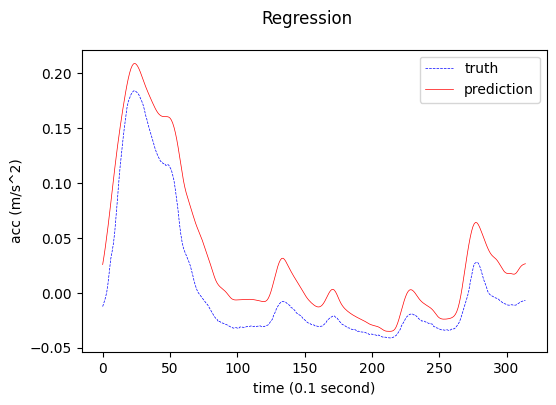

vehicle 82  MSE Loss: 0.00124260


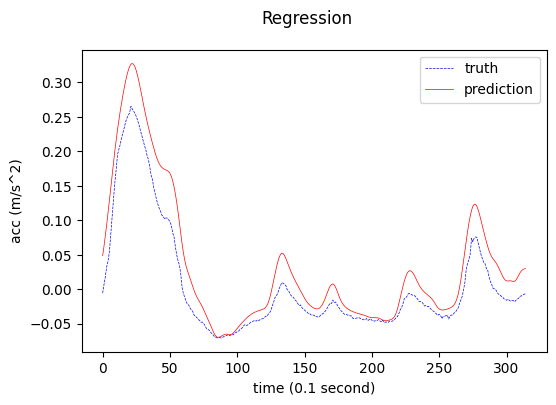

vehicle 83  MSE Loss: 0.00103645


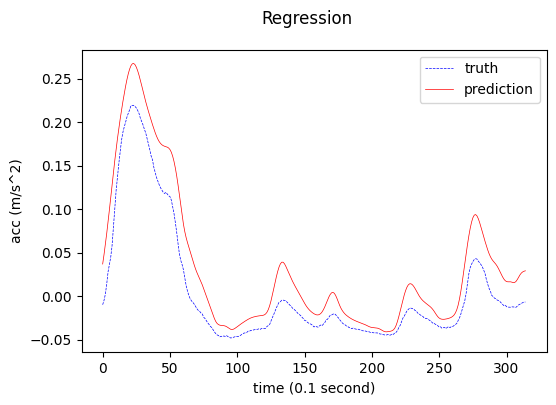

vehicle 84  MSE Loss: 0.00098600


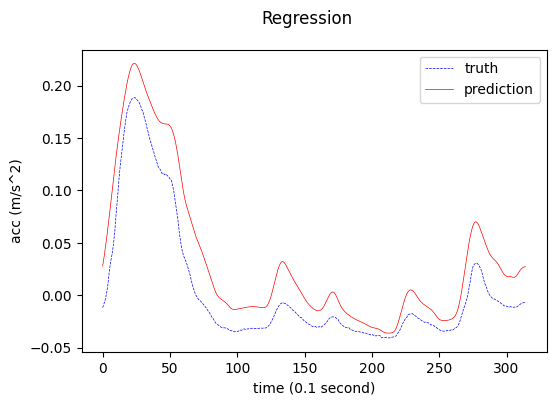

vehicle 85  MSE Loss: 0.00119581


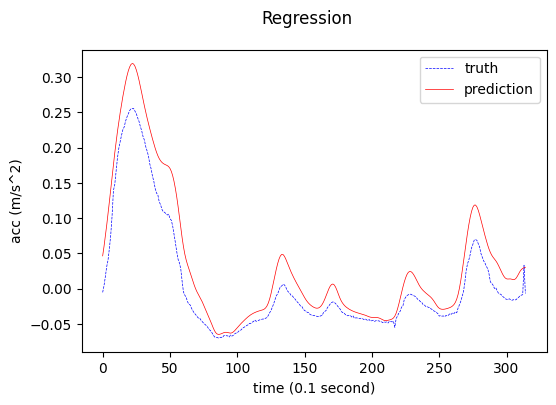

vehicle 86  MSE Loss: 0.00117320


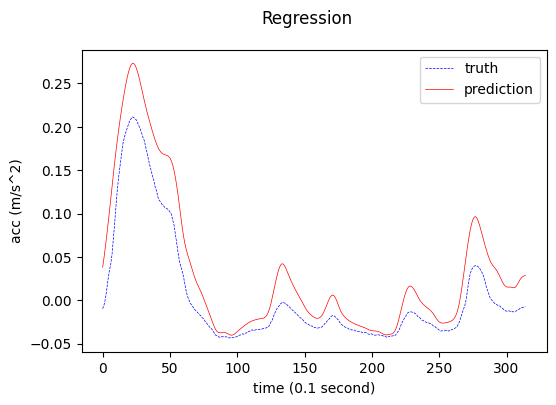

vehicle 87  MSE Loss: 0.00122538


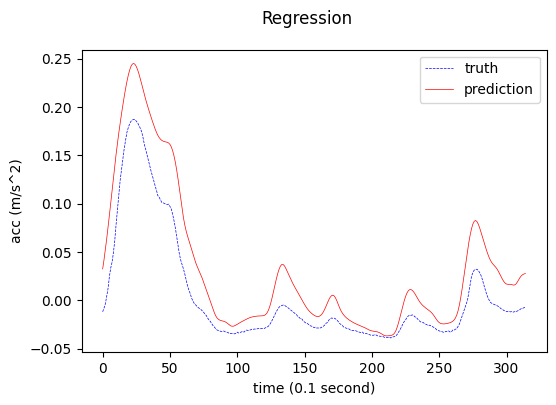

vehicle 88  MSE Loss: 0.00143021


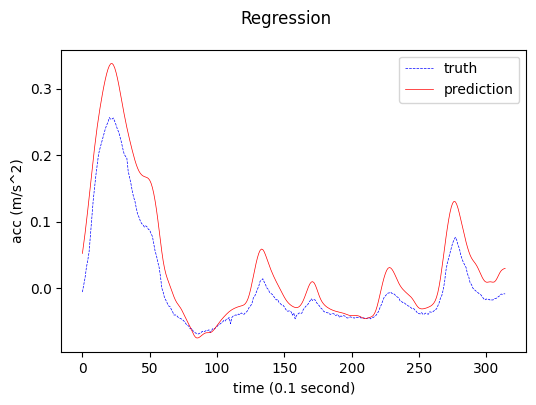

vehicle 89  MSE Loss: 0.00111370


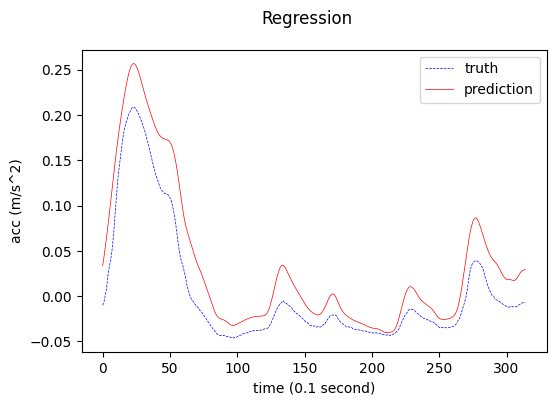

vehicle 90  MSE Loss: 0.00112867


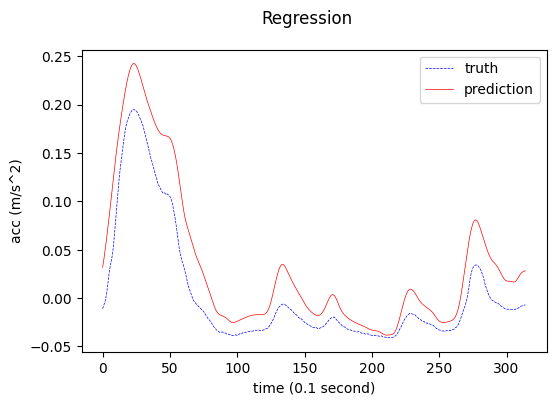

vehicle 91  MSE Loss: 0.00133236


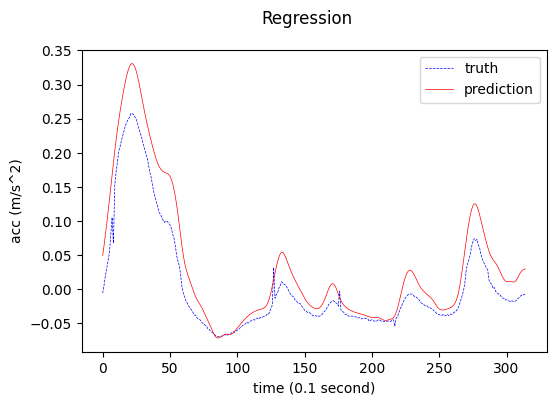

vehicle 92  MSE Loss: 0.00110353


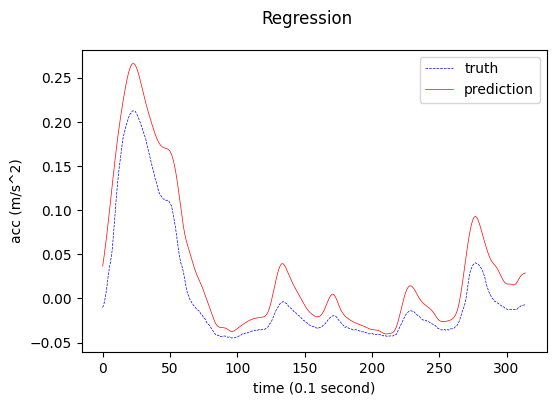

vehicle 93  MSE Loss: 0.00133774


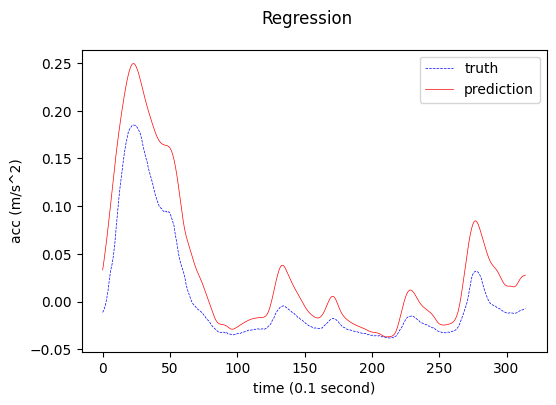

vehicle 94  MSE Loss: 0.00130324


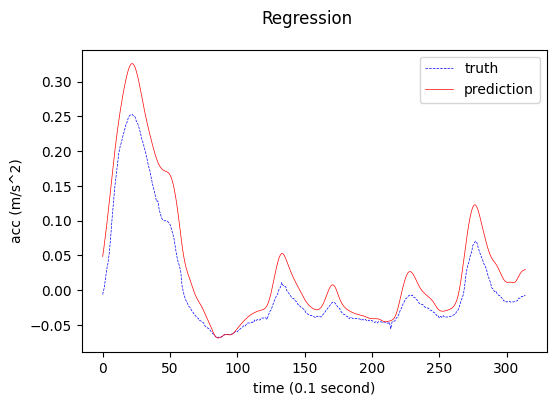

vehicle 95  MSE Loss: 0.00094221


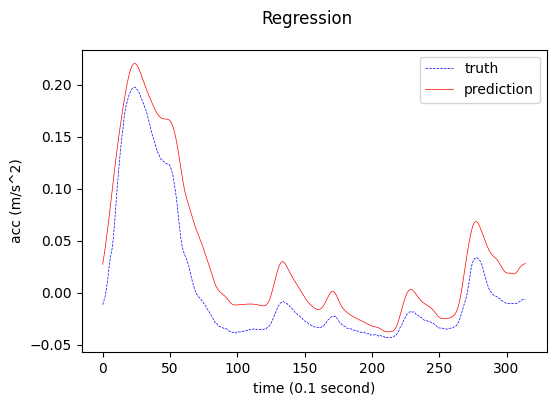

vehicle 96  MSE Loss: 0.00112079


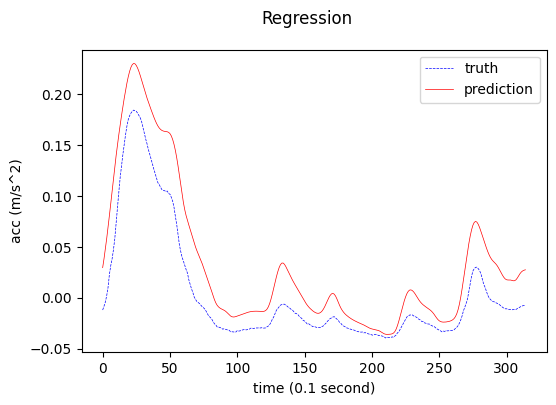

vehicle 97  MSE Loss: 0.00152814


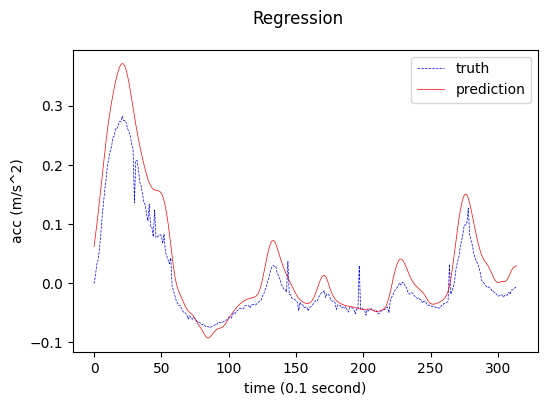

vehicle 98  MSE Loss: 0.00097090


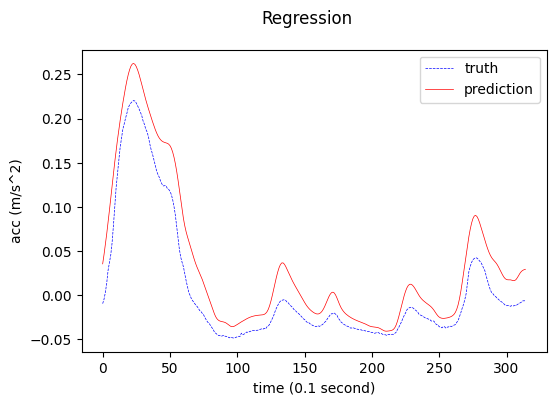

vehicle 99  MSE Loss: 0.00090582


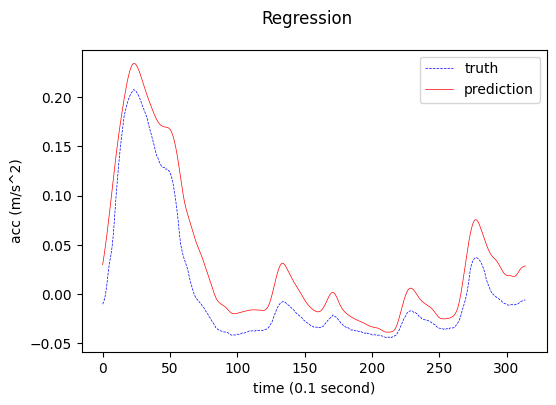

average MSE loss: 0.0011553907522466034


In [8]:
MSE = []
num_test = testing_size
test_X = Variable(torch.empty(sample_len, seq_length, 3))
test_Y = Variable(torch.empty(sample_len,1))
    
for k in range(testing_size):
    test_X = testX[k*sample_len:k*sample_len+sample_len] # 0 to test_size
    test_Y = testY[k*sample_len:k*sample_len+sample_len]

    test_X = test_X.to(device)
    test_Y = test_Y.to(device)
    ##########################################
    model.eval()
    predict = model(test_X)
    
    loss = (np.square(predict.cpu().data.numpy() - test_Y.cpu().data.numpy())).mean(axis=None)
    #loss = nn.MSELoss(predict, test_Y)
    MSE.append(loss)
    print("vehicle %d  MSE Loss: %1.8f" % (k, loss.item()))
    plt.figure(dpi=100)
    plt.plot(predict.cpu().data.numpy(),c='b', linewidth=0.5, label = 'truth', linestyle='dashed')
    plt.plot(test_Y.cpu().data.numpy(),c='r', linewidth=0.5, label = 'prediction')
    plt.xlabel('time (0.1 second)')
    plt.ylabel('acc (m/s^2)')
    plt.suptitle('Regression')
    plt.legend()
    plt.show()

print('average MSE loss:', sum(MSE)/num_test)


In [ ]:
quit()